In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score


In [48]:
df_train = pd.read_csv("Data/train.csv")
df_test = pd.read_csv('Data/test.csv')
df_hawk = pd.read_csv('Data/auxiliary-data/sg-gov-hawkers.csv')
df_hdb = pd.read_csv('Data/auxiliary-data/sg-hdb-block-details.csv')
df_mrt = pd.read_csv('Data/auxiliary-data/sg-mrt-stations.csv')
df_ps = pd.read_csv('Data/auxiliary-data/sg-primary-schools.csv')
df_ss = pd.read_csv('Data/auxiliary-data/sg-secondary-schools.csv')
df_mall = pd.read_csv('Data/auxiliary-data/sg-shopping-malls.csv')
df_child = pd.read_csv('Data/auxiliary-data/childcare.csv')
df_cc = pd.read_csv('Data/auxiliary-data/communityclubs.csv')
df_ht = pd.read_csv('Data/auxiliary-data/heritagetrees.csv')
df_lib = pd.read_csv('Data/auxiliary-data/libraries.csv')
df_hosp = pd.read_csv('Data/auxiliary-data/moh_hospitals.csv')
df_park = pd.read_csv('Data/auxiliary-data/nationalparks.csv')
df_pharma = pd.read_csv('Data/auxiliary-data/registered_pharmacy.csv')

In [49]:
def clean_train_test_dataframe(df, is_test=False):
    def floor_range_avg(rng):
        upper, lower = rng.split(" to ")
        upper = int(upper)
        lower = int(lower)
        return (upper + lower)/2

    df['BLOCK'] = df['BLOCK'].str.strip().str.lower()
    df['STREET'] = df['STREET'].str.strip().str.lower()

    df["ADDRESS"] = df['BLOCK'] + " " + df['STREET']

    df['FLAT_TYPE'] = df['FLAT_TYPE'].str.replace('-', ' ').str.strip().str.lower()

    df['YEAR'] = df['MONTH'].str.split('-').str[0].astype(int)
    df['MONTH'] = df['MONTH'].str.split('-').str[1].astype(int)

    df["FLOOR"] = df["FLOOR_RANGE"].apply(floor_range_avg)
    df["FLAT_AGE"] = df["YEAR"] - df["LEASE_COMMENCE_DATA"]

    df = df.drop('ECO_CATEGORY', axis=1)
    df = df.drop('FLOOR_RANGE', axis=1)
    df = df.drop('BLOCK', axis=1)
    df = df.drop('STREET', axis=1)

    if not is_test:
        df.drop_duplicates(inplace=True)

    return df

In [50]:
def clean_df_hdb(df):
    df["ADDRESS"] = df["ADDRESS"].str.strip().str.lower()
    df["BLOCK"] = df["BLOCK"].str.strip().str.lower()

    df["ADDRESS"] = df["BLOCK"] + " " + df["ADDRESS"]

    return df.drop('BLOCK', axis=1)

def remove_near_duplicate_schools(df):
    df = df.drop_duplicates(subset=['LATITUDE', 'LONGITUDE'], keep='last')
    return df

In [51]:
df_train = clean_train_test_dataframe(df_train)
df_test = clean_train_test_dataframe(df_test, is_test=True)

df_hdb = clean_df_hdb(df_hdb)

In [52]:
def convert_to_coordinates(df, df_coords):
    df = df.merge(
        df_coords[['ADDRESS', 'LATITUDE', 'LONGITUDE', 'MAX_FLOOR']],
        on=['ADDRESS'],
        how='left'
    )
    return df

def calculate_distance_and_metadata(feature, df_features, df_main, meta_cols=None):
    tree = BallTree(np.radians(df_features[['LATITUDE', 'LONGITUDE']].to_numpy()), metric='haversine')
    distances, indices = tree.query(np.radians(df_main[['LATITUDE', 'LONGITUDE']].to_numpy()), k=10)
    distances_km = distances * 6371

    df_main[f"DIST_AVG_{feature}"] = np.mean(distances_km, axis=1)

    if meta_cols:
        nearest_idx = indices[:, 0]
        for col in meta_cols:
            df_main[f"{feature}_{col}"] = df_features.iloc[nearest_idx][col].values

def augment_auxiliary_data(df, mrt, shopping, hawker, ps, ss, child, cc, ht, lib, hosp, park, pharma):
    calculate_distance_and_metadata("MRT", mrt, df, meta_cols=["STATUS"])
    calculate_distance_and_metadata("OPEN_MRT", mrt[mrt["STATUS"] == "open"], df)
    calculate_distance_and_metadata("SHOPPING_MALL", shopping, df)
    calculate_distance_and_metadata(
        "HAWKER_CENTRE", hawker, df,
        meta_cols=["TYPE", "OWNER", "NUMBER_OF_STALLS"]
    )
    calculate_distance_and_metadata("PRIMARY_SCHOOL", ps, df)
    calculate_distance_and_metadata("SECONDARY_SCHOOL", ss, df)
    calculate_distance_and_metadata("CHILDCARE", child, df)
    calculate_distance_and_metadata("COMMUNITY_CLUBS", cc, df)
    calculate_distance_and_metadata("HERITAGE_TREES", ht, df)
    calculate_distance_and_metadata("LIBRARIES", lib, df)
    calculate_distance_and_metadata("HOSPITALS", hosp, df)
    calculate_distance_and_metadata("NATIONAL_PARKS", park, df)
    calculate_distance_and_metadata("PHARMACIES", pharma, df)
    return df


In [53]:
df_train = convert_to_coordinates(df_train, df_hdb)
df_test = convert_to_coordinates(df_test, df_hdb)

df_train = augment_auxiliary_data(df_train, df_mrt, df_mall, df_hawk, df_ps, df_ss, df_child, df_cc, df_ht, df_lib, df_hosp, df_park, df_pharma)
df_test = augment_auxiliary_data(df_test, df_mrt, df_mall, df_hawk, df_ps, df_ss, df_child, df_cc, df_ht, df_lib, df_hosp, df_park, df_pharma)

In [54]:
list(set(df_train.select_dtypes(include=['number'])).difference(set(["RESALE_PRICE"])))

['DIST_AVG_HERITAGE_TREES',
 'LATITUDE',
 'DIST_AVG_CHILDCARE',
 'FLOOR',
 'HAWKER_CENTRE_NUMBER_OF_STALLS',
 'MAX_FLOOR',
 'LEASE_COMMENCE_DATA',
 'YEAR',
 'LONGITUDE',
 'DIST_AVG_OPEN_MRT',
 'DIST_AVG_HOSPITALS',
 'DIST_AVG_PRIMARY_SCHOOL',
 'DIST_AVG_HAWKER_CENTRE',
 'DIST_AVG_PHARMACIES',
 'DIST_AVG_COMMUNITY_CLUBS',
 'DIST_AVG_SHOPPING_MALL',
 'DIST_AVG_SECONDARY_SCHOOL',
 'DIST_AVG_MRT',
 'DIST_AVG_LIBRARIES',
 'FLOOR_AREA_SQM',
 'FLAT_AGE',
 'DIST_AVG_NATIONAL_PARKS',
 'MONTH']

In [55]:
list(set(df_train).difference(set(df_train.select_dtypes(include=['number']))))

['TOWN',
 'FLAT_TYPE',
 'MRT_STATUS',
 'ADDRESS',
 'HAWKER_CENTRE_OWNER',
 'FLAT_MODEL',
 'HAWKER_CENTRE_TYPE']

# Model Selection

In [56]:
target = 'RESALE_PRICE'

num_features = [
    'DIST_AVG_NATIONAL_PARKS',
    'DIST_AVG_SHOPPING_MALL',
    'DIST_AVG_PRIMARY_SCHOOL',
    'DIST_AVG_CHILDCARE',
    'DIST_AVG_HERITAGE_TREES',
    'DIST_AVG_OPEN_MRT',
    'DIST_AVG_SECONDARY_SCHOOL',
    'DIST_AVG_MRT',
    'DIST_AVG_LIBRARIES',
    'DIST_AVG_HAWKER_CENTRE',
    'DIST_AVG_PHARMACIES',
    'DIST_AVG_HOSPITALS',
    'DIST_AVG_COMMUNITY_CLUBS',
    'LATITUDE',
    'LONGITUDE',
    'YEAR',
    'MONTH',
    'FLAT_AGE',
    'FLOOR',
    'FLOOR_AREA_SQM',
    'MAX_FLOOR',
    'LEASE_COMMENCE_DATA',
    'HAWKER_CENTRE_NUMBER_OF_STALLS'
]

cat_features = [
    'HAWKER_CENTRE_TYPE',
    'HAWKER_CENTRE_OWNER',
    'FLAT_MODEL',
    'FLAT_TYPE',
    'MRT_STATUS',
    'TOWN',
]

features = cat_features + num_features

In [57]:
X = df_train[features].copy()
y = df_train[target].copy()

In [58]:
for col in cat_features:
     X[col] = X[col].astype("category")

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [68]:
best_params = {
    'subsample': 1.0,
    'reg_lambda': 3,
    'reg_alpha': 0,
    'min_child_weight': 7,
    'max_depth': 6,
    'learning_rate': 0.05,
    'gamma': 0.2,
    'colsample_bytree': 0.5
}

model = XGBRegressor(
    **best_params,
    n_estimators=2000,
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    tree_method='hist',
    verbosity=0,
    enable_categorical=True
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

cv_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf, n_jobs=-1, verbose=1)

mean_rmse = -np.mean(cv_scores)
std_rmse = np.std(cv_scores)

print("\n5-Fold Cross-Validation Results:")
print(f"RMSE scores (per fold): {-cv_scores}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Std RMSE: {std_rmse:.4f}\n")

final_xgb = XGBRegressor(
    **best_params,
    n_estimators=2000,
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    early_stopping_rounds=100,
    tree_method='hist',
    enable_categorical=True,
    verbosity=1
)

final_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

y_pred = final_xgb.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("\nFinal Model Evaluation (Validation Set):")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   50.7s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.3s finished



5-Fold Cross-Validation Results:
RMSE scores (per fold): [25234.69449938 25197.03757407 25044.7130582  25181.302526
 25123.76130358]
Mean RMSE: 25156.3018
Std RMSE: 66.2432

[0]	validation_0-rmse:176841.78381	validation_1-rmse:175094.49767
[50]	validation_0-rmse:55669.02018	validation_1-rmse:55314.32976
[100]	validation_0-rmse:38173.66962	validation_1-rmse:38230.04019
[150]	validation_0-rmse:33679.71587	validation_1-rmse:33959.35850
[200]	validation_0-rmse:31421.69161	validation_1-rmse:31857.09091
[250]	validation_0-rmse:29857.91161	validation_1-rmse:30442.20895
[300]	validation_0-rmse:28589.18851	validation_1-rmse:29291.84826
[350]	validation_0-rmse:27719.80247	validation_1-rmse:28540.42000
[400]	validation_0-rmse:26968.46868	validation_1-rmse:27902.16980
[450]	validation_0-rmse:26347.81831	validation_1-rmse:27378.21086
[500]	validation_0-rmse:25898.07781	validation_1-rmse:27004.14918
[550]	validation_0-rmse:25477.77299	validation_1-rmse:26666.74594
[600]	validation_0-rmse:25129.8578

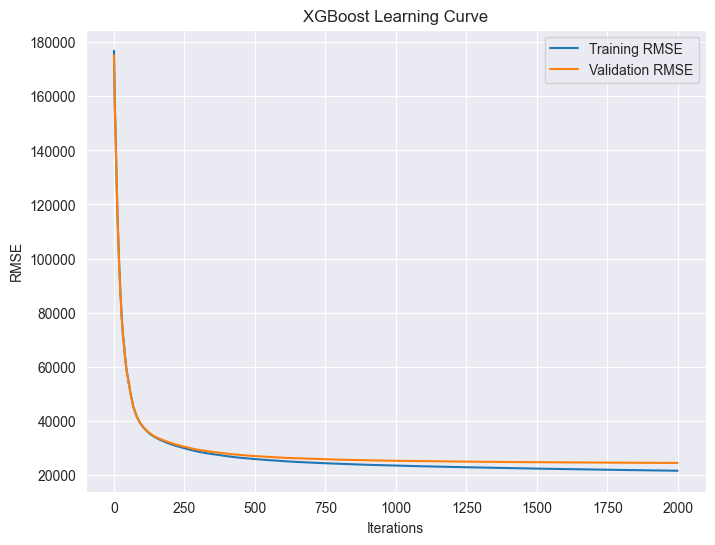

In [69]:
evals_result = final_xgb.evals_result_
train_rmse = evals_result['validation_0']['rmse']
val_rmse = evals_result['validation_1']['rmse']

plt.figure(figsize=(8, 6))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
X_test = df_test[features].copy()

for col in cat_features:
     X_test[col] = X_test[col].astype("category")

y_test_pred = final_xgb.predict(X_test)

submission = pd.DataFrame({
    "Id": df_test.index,
    "Predicted": y_test_pred
})

submission.to_csv("Data/submission_xgb.csv", index=False)

In [63]:
train_pool_full = Pool(X, y, cat_features=cat_features)

params = {
    'subsample': 0.7,
    'iterations': 2000,
    'learning_rate': 0.05,
    'depth': 10,
    'l2_leaf_reg': 5,
    'colsample_bylevel': 1.0,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'early_stopping_rounds': 100,
    'task_type': 'CPU',
    'devices': '0'
}

cv_data = cv(
    params=params,
    pool=train_pool_full,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    verbose=False,
    plot=False
)

mean_rmse = cv_data['test-RMSE-mean'].iloc[-1]
std_rmse = cv_data['test-RMSE-std'].iloc[-1]

print("\n5-Fold Cross-Validation Results:")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Std RMSE: {std_rmse:.4f}\n")

train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)

final_cat = CatBoostRegressor(**params, verbose=100)

final_cat.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True
)

val_preds = final_cat.predict(val_pool)

mse = mean_squared_error(y_val, val_preds)
mae = mean_absolute_error(y_val, val_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, val_preds)

print("\nFinal Model Evaluation (Validation Set):")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Training on fold [0/5]

bestTest = 25297.95667
bestIteration = 1999

Training on fold [1/5]

bestTest = 24735.17038
bestIteration = 1997

Training on fold [2/5]

bestTest = 24943.05421
bestIteration = 1999

Training on fold [3/5]

bestTest = 24981.62744
bestIteration = 1999

Training on fold [4/5]

bestTest = 24680.12941
bestIteration = 1999


5-Fold Cross-Validation Results:
Mean RMSE: 24927.7350
Std RMSE: 244.0848

0:	learn: 176097.0731870	test: 174412.9101140	best: 174412.9101140 (0)	total: 178ms	remaining: 5m 56s
100:	learn: 38665.4508028	test: 38594.7175022	best: 38594.7175022 (100)	total: 15.1s	remaining: 4m 44s
200:	learn: 31382.2881122	test: 31710.5593634	best: 31710.5593634 (200)	total: 25.3s	remaining: 3m 46s
300:	learn: 28390.6868065	test: 28959.2629632	best: 28959.2629632 (300)	total: 35.6s	remaining: 3m 20s
400:	learn: 26716.2951274	test: 27477.2932041	best: 27477.2932041 (400)	total: 46.8s	remaining: 3m 6s
500:	learn: 25565.3290390	test: 26539.9041331	best: 26539.9041331 

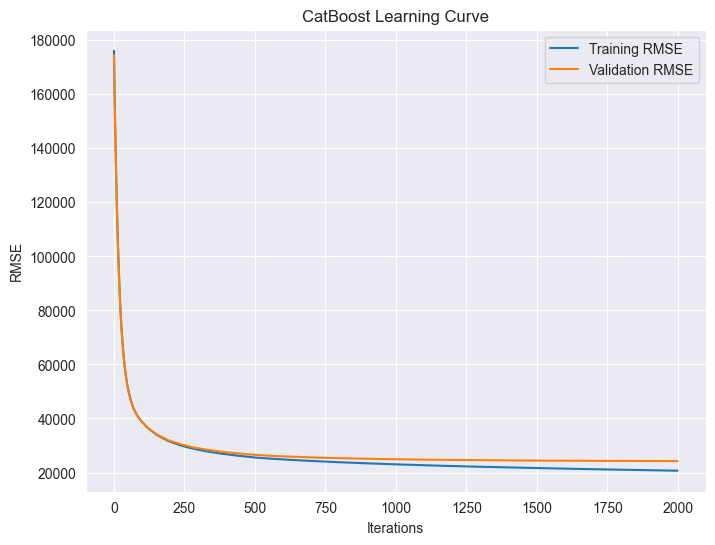

In [64]:
import matplotlib.pyplot as plt

evals_result = final_cat.evals_result_
train_rmse = evals_result['learn']['RMSE']
val_rmse = evals_result['validation']['RMSE']

plt.figure(figsize=(8, 6))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('CatBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
X_test = df_test[features].copy()

test_pool = Pool(X_test, cat_features=cat_features)

y_test_pred = final_cat.predict(test_pool)

submission = pd.DataFrame({
    "Id": df_test.index,
    "Predicted": y_test_pred
})

submission.to_csv("Data/submission_catboost.csv", index=False)

In [65]:
from lightgbm import LGBMRegressor

best_params = {
    'subsample': 0.8,
    'reg_lambda': 7,
    'reg_alpha': 0.1,
    'num_leaves': 31,
    'min_child_weight': 7,
    'max_depth': 10,
    'learning_rate': 0.1,
    'colsample_bytree':0.5
}

model = LGBMRegressor(
    **best_params,
    n_estimators=2000,
    objective='regression',
    metric='rmse',
    random_state=42,
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

cv_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf, n_jobs=-1, verbose=1)

mean_rmse = -np.mean(cv_scores)
std_rmse = np.std(cv_scores)

print("\n5-Fold Cross-Validation Results:")
print(f"RMSE scores (per fold): {-cv_scores}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Std RMSE: {std_rmse:.4f}\n")


final_light = LGBMRegressor(
    **best_params,
    n_estimators=2000,
    objective='regression',
    metric='rmse',
    random_state=42,
)

final_light.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='rmse',
)

y_pred = final_light.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("\nFinal Model Evaluation (Validation Set):")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4323
[LightGBM] [Info] Number of data points in the train set: 129971, number of used features: 29
[LightGBM] [Info] Start training from score 518852.607602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4320
[LightGBM] [Info] Number of data points in the train set: 129971, number of used features: 29
[LightGBM] [Info] Start training from score 518866.276486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4324
[LightGBM] [Info] Number of data points in t

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished



5-Fold Cross-Validation Results:
RMSE scores (per fold): [25219.05043717 25095.83757669 24976.34206908 25129.69486369
 25167.39133642]
Mean RMSE: 25117.6633
Std RMSE: 81.6640

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4324
[LightGBM] [Info] Number of data points in the train set: 146217, number of used features: 29
[LightGBM] [Info] Start training from score 518926.422154

Final Model Evaluation (Validation Set):
Mean Squared Error: 595290233.8905
Mean Absolute Error: 17714.4796
Root Mean Squared Error: 24398.5703
R² Score: 0.9820


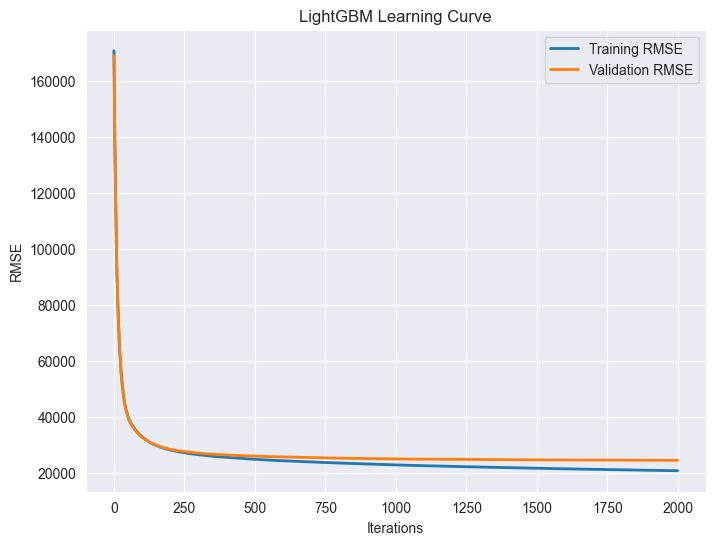

In [66]:
import matplotlib.pyplot as plt

evals_result = final_light.evals_result_

train_rmse = evals_result['training']['rmse']
val_rmse = evals_result['valid_1']['rmse']

plt.figure(figsize=(8, 6))
plt.plot(train_rmse, label='Training RMSE', linewidth=2)
plt.plot(val_rmse, label='Validation RMSE', linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


In [67]:
train_rmse[1999]

np.float64(20673.05510414797)

In [43]:
X_test = df_test[features].copy()

for col in cat_features:
     X_test[col] = X_test[col].astype("category")

y_test_pred = final_light.predict(X_test)

submission = pd.DataFrame({
    "Id": df_test.index,
    "Predicted": y_test_pred
})

submission.to_csv("Data/submission_lightgbm.csv", index=False)